In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess a single CSV file
def load_and_preprocess_csv(file_path):
    data = pd.read_csv(file_path)

    # Normalize counts for each slice_index
    data['count'] = data.groupby('slice_index')['count'].transform(lambda x: x / x.sum())

    # Normalize bin edges for each slice_index
    data['bin_start'] = data.groupby('slice_index')['bin_start'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    data['bin_end'] = data.groupby('slice_index')['bin_end'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    # Pivot the data to create a 2D array
    pivot_data = data.pivot(index='slice_index', columns='bin_start', values='count').fillna(0)
    return pivot_data

# Function to pad arrays to the same shape
def pad_array(array, max_shape):
    pad_width = [(0, max_shape[i] - array.shape[i]) for i in range(len(array.shape))]
    padded_array = np.pad(array, pad_width, mode='constant', constant_values=0)
    return padded_array

# Function to load data from a directory
def load_data_from_directory(directory, global_max_shape):
    positive_files = sorted([f for f in os.listdir(directory) if f.startswith('positive')])
    negative_files = sorted([f for f in os.listdir(directory) if f.startswith('negative')])
    
    signals = []
    labels = []

    # Process each pair of positive and negative files
    for pos_file, neg_file in zip(positive_files, negative_files):
        pos_data = load_and_preprocess_csv(os.path.join(directory, pos_file))
        neg_data = load_and_preprocess_csv(os.path.join(directory, neg_file))
        combined_data = np.concatenate((pos_data, neg_data), axis=1)
        padded_data = pad_array(combined_data, global_max_shape)
        signals.append(padded_data)
        labels.append(1 if 'Glitch_volumes' in directory else 0)
    
    return np.array(signals), np.array(labels)

# Function to determine the global max shape across all directories
def determine_global_max_shape(directories):
    max_shape = (0, 0)
    for directory in directories:
        positive_files = sorted([f for f in os.listdir(directory) if f.startswith('positive')])
        negative_files = sorted([f for f in os.listdir(directory) if f.startswith('negative')])
        for pos_file, neg_file in zip(positive_files, negative_files):
            pos_data = load_and_preprocess_csv(os.path.join(directory, pos_file))
            neg_data = load_and_preprocess_csv(os.path.join(directory, neg_file))
            combined_data = np.concatenate((pos_data, neg_data), axis=1)
            max_shape = (max(max_shape[0], combined_data.shape[0]), max(max_shape[1], combined_data.shape[1]))
    return max_shape

# Function to load data from multiple directories with a global max shape
def load_data_from_multiple_directories(directories, global_max_shape):
    all_signals = []
    all_labels = []
    for directory in directories:
        signals, labels = load_data_from_directory(directory, global_max_shape)
        all_signals.extend(signals)
        all_labels.extend(labels)
    return np.array(all_signals), np.array(all_labels)

# Define the directories
merger_directories = [
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1200MPC-1-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1200MPC-2-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1200MPC-3-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1000MPC-1-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1000MPC-2-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1000MPC-3-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/800MPC-1-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/800MPC-2-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/800MPC-3-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/600MPC-1-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/600MPC-2-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/600MPC-3-Noisy'
]
glitch_directories = [
    '/home/arutkeerthi/Downloads/Glitchveto/Glitch_volumes'
]

# Determine the global max shape for both merger and glitch directories
global_max_shape = determine_global_max_shape(merger_directories + glitch_directories)
np.save('/home/arutkeerthi/Downloads/Glitchveto/global_max_shape.npy', global_max_shape)

# Load the merger and glitch data with the global max shape
X_merger, y_merger = load_data_from_multiple_directories(merger_directories, global_max_shape)
X_glitch, y_glitch = load_data_from_multiple_directories(glitch_directories, global_max_shape)

# Combine merger and glitch data
X = np.concatenate((X_merger, X_glitch), axis=0)
y = np.concatenate((y_merger, y_glitch), axis=0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the CNN model
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)

x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.25)(x)

x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

model.save('/home/arutkeerthi/Downloads/Glitchveto/Model_3.hdf5')

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Print training and validation accuracy per epoch
for epoch, acc in enumerate(history.history['accuracy'], 1):
    print(f'Epoch {epoch}: Training Accuracy = {acc}')

for epoch, val_acc in enumerate(history.history['val_accuracy'], 1):
    print(f'Epoch {epoch}: Validation Accuracy = {val_acc}')



2024-09-16 15:12:17.165531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-16 15:12:17.166216: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20


2024-09-16 15:12:19.440257: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 817358388 exceeds 10% of free system memory.


 3/39 [=>............................] - ETA: 1s - loss: 0.6889 - accuracy: 0.4583 

2024-09-16 15:12:20.794930: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21110144 exceeds 10% of free system memory.
2024-09-16 15:12:20.794992: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21110144 exceeds 10% of free system memory.
2024-09-16 15:12:20.795031: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21110144 exceeds 10% of free system memory.
2024-09-16 15:12:20.795095: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21110144 exceeds 10% of free system memory.


39/39 [==============================] - 3s 51ms/step - loss: 0.2937 - accuracy: 0.9209 - val_loss: 2.4015e-04 - val_accuracy: 1.0000
Epoch 2/20
39/39 [==============================] - 1s 33ms/step - loss: 8.0371e-05 - accuracy: 1.0000 - val_loss: 5.9408e-06 - val_accuracy: 1.0000
Epoch 3/20
39/39 [==============================] - 1s 33ms/step - loss: 2.3676e-05 - accuracy: 1.0000 - val_loss: 4.1181e-06 - val_accuracy: 1.0000
Epoch 4/20
39/39 [==============================] - 1s 33ms/step - loss: 1.3899e-05 - accuracy: 1.0000 - val_loss: 3.6928e-06 - val_accuracy: 1.0000
Epoch 5/20
39/39 [==============================] - 1s 33ms/step - loss: 1.6087e-05 - accuracy: 1.0000 - val_loss: 3.2525e-06 - val_accuracy: 1.0000
Epoch 6/20
39/39 [==============================] - 1s 33ms/step - loss: 1.6564e-05 - accuracy: 1.0000 - val_loss: 2.9533e-06 - val_accuracy: 1.0000
Epoch 7/20
39/39 [==============================] - 1s 33ms/step - loss: 9.6658e-06 - accuracy: 1.0000 - val_loss: 2.7087

/home/arutkeerthi/miniconda3/envs/rtp/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 9ms/step - loss: 1.0206e-06 - accuracy: 1.0000
Test accuracy: 1.0
Epoch 1: Training Accuracy = 0.9209039807319641
Epoch 2: Training Accuracy = 1.0
Epoch 3: Training Accuracy = 1.0
Epoch 4: Training Accuracy = 1.0
Epoch 5: Training Accuracy = 1.0
Epoch 6: Training Accuracy = 1.0
Epoch 7: Training Accuracy = 1.0
Epoch 8: Training Accuracy = 1.0
Epoch 9: Training Accuracy = 1.0
Epoch 10: Training Accuracy = 1.0
Epoch 11: Training Accuracy = 1.0
Epoch 12: Training Accuracy = 1.0
Epoch 13: Training Accuracy = 1.0
Epoch 14: Training Accuracy = 1.0
Epoch 15: Training Accuracy = 1.0
Epoch 16: Training Accuracy = 1.0
Epoch 17: Training Accuracy = 1.0
Epoch 18: Training Accuracy = 1.0
Epoch 19: Training Accuracy = 1.0
Epoch 20: Training Accuracy = 1.0
Epoch 1: Validation Accuracy = 1.0
Epoch 2: Validation Accuracy = 1.0
Epoch 3: Validation Accuracy = 1.0
Epoch 4: Validation Accuracy = 1.0
Epoch 5: Validation Accuracy = 1.0
Epoch 6: Validation Accuracy 

10/10 [==============================] - 0s 16ms/step


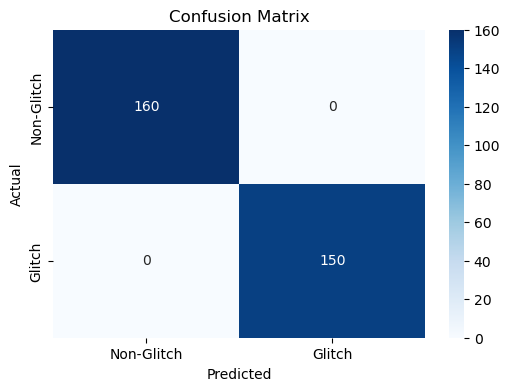

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess a single CSV file
def load_and_preprocess_csv(file_path):
    data = pd.read_csv(file_path)

    # Normalize counts for each slice_index
    data['count'] = data.groupby('slice_index')['count'].transform(lambda x: x / x.sum())

    # Normalize bin edges for each slice_index
    data['bin_start'] = data.groupby('slice_index')['bin_start'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    data['bin_end'] = data.groupby('slice_index')['bin_end'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    # Pivot the data to create a 2D array
    pivot_data = data.pivot(index='slice_index', columns='bin_start', values='count').fillna(0)
    return pivot_data

# Function to pad arrays to the same shape
def pad_array(array, max_shape):
    pad_width = [(0, max_shape[i] - array.shape[i]) for i in range(len(array.shape))]
    padded_array = np.pad(array, pad_width, mode='constant', constant_values=0)
    return padded_array

# Function to load data from a directory
def load_data_from_directory(directory, global_max_shape):
    positive_files = sorted([f for f in os.listdir(directory) if f.startswith('positive')])
    negative_files = sorted([f for f in os.listdir(directory) if f.startswith('negative')])
    
    signals = []
    labels = []

    # Process each pair of positive and negative files
    for pos_file, neg_file in zip(positive_files, negative_files):
        pos_data = load_and_preprocess_csv(os.path.join(directory, pos_file))
        neg_data = load_and_preprocess_csv(os.path.join(directory, neg_file))
        combined_data = np.concatenate((pos_data, neg_data), axis=1)
        padded_data = pad_array(combined_data, global_max_shape)
        signals.append(padded_data)
        labels.append(1 if 'Glitch_volumes' in directory else 0)
    
    return np.array(signals), np.array(labels)

# Function to determine the global max shape across all directories
def determine_global_max_shape(directories):
    max_shape = (0, 0)
    for directory in directories:
        positive_files = sorted([f for f in os.listdir(directory) if f.startswith('positive')])
        negative_files = sorted([f for f in os.listdir(directory) if f.startswith('negative')])
        for pos_file, neg_file in zip(positive_files, negative_files):
            pos_data = load_and_preprocess_csv(os.path.join(directory, pos_file))
            neg_data = load_and_preprocess_csv(os.path.join(directory, neg_file))
            combined_data = np.concatenate((pos_data, neg_data), axis=1)
            max_shape = (max(max_shape[0], combined_data.shape[0]), max(max_shape[1], combined_data.shape[1]))
    return max_shape

# Function to load data from multiple directories with a global max shape
def load_data_from_multiple_directories(directories, global_max_shape):
    all_signals = []
    all_labels = []
    for directory in directories:
        signals, labels = load_data_from_directory(directory, global_max_shape)
        all_signals.extend(signals)
        all_labels.extend(labels)
    return np.array(all_signals), np.array(all_labels)

# Define the directories
merger_directories = [
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1200MPC-1-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1200MPC-2-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1200MPC-3-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1000MPC-1-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1000MPC-2-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/1000MPC-3-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/800MPC-1-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/800MPC-2-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/800MPC-3-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/600MPC-1-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/600MPC-2-Noisy',
    '/home/arutkeerthi/Downloads/Glitchveto/Merger_volumes/600MPC-3-Noisy'
]
glitch_directories = [
    '/home/arutkeerthi/Downloads/Glitchveto/Glitch_volumes_new'
]

# Determine the global max shape for both merger and glitch directories
global_max_shape = np.load('/home/arutkeerthi/Downloads/Glitchveto/global_max_shape.npy')

# Load the merger and glitch data with the global max shape
X_merger, y_merger = load_data_from_multiple_directories(merger_directories, global_max_shape)
X_glitch, y_glitch = load_data_from_multiple_directories(glitch_directories, global_max_shape)

# Combine merger and glitch data
X = np.concatenate((X_merger, X_glitch), axis=0)
y = np.concatenate((y_merger, y_glitch), axis=0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# Load the saved model
model = load_model('/home/arutkeerthi/Downloads/Glitchveto/Model_3.hdf5')

# Load your test data (X_test and y_test should already be split)
# If they were saved before, you can load them again, or if they're still in memory, directly use them.
# Assuming they are already in memory as X_test and y_test

# Predict on the test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert from probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded, convert it to class labels

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Glitch', 'Glitch'], yticklabels=['Non-Glitch', 'Glitch'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Function to load and preprocess a single CSV file
def load_and_preprocess_csv(file_path):
    data = pd.read_csv(file_path)

    # Normalize counts for each slice_index
    data['count'] = data.groupby('slice_index')['count'].transform(lambda x: x / x.sum())

    # Normalize bin edges for each slice_index
    data['bin_start'] = data.groupby('slice_index')['bin_start'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    data['bin_end'] = data.groupby('slice_index')['bin_end'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    # Pivot the data to create a 2D array
    pivot_data = data.pivot(index='slice_index', columns='bin_start', values='count').fillna(0)
    return pivot_data

# Function to pad arrays to the same shape
def pad_array(array, max_shape):
    pad_width = [(0, max_shape[i] - array.shape[i]) for i in range(len(array.shape))]
    padded_array = np.pad(array, pad_width, mode='constant', constant_values=0)
    return padded_array

# Load the previously saved max_shape
max_shape = np.load('/home/arutkeerthi/Downloads/Glitchveto/global_max_shape.npy')

# Load the trained model
model = load_model('/home/arutkeerthi/Downloads/Glitchveto/Model_3.hdf5')

# Paths to the new CSV files
positive_csv_path = '/home/arutkeerthi/Downloads/Glitchveto/Glitch_volumes_new/positive_71.csv'
negative_csv_path = '/home/arutkeerthi/Downloads/Glitchveto/Glitch_volumes_new/negative_71.csv'

# Preprocess the new data
positive_data = load_and_preprocess_csv(positive_csv_path)
negative_data = load_and_preprocess_csv(negative_csv_path)

# Combine and pad the new data
positive_data_padded = pad_array(positive_data.values, max_shape)
negative_data_padded = pad_array(negative_data.values, max_shape)

# Create data arrays for prediction
new_data = np.array([positive_data_padded, negative_data_padded])

# Make predictions
predictions = model.predict(new_data)

# Interpret predictions
labels = ['Non-Glitch', 'Glitch']
for i, prediction in enumerate(predictions):
    predicted_label = labels[np.argmax(prediction)]
    print(f'Prediction for file {i + 1}: {predicted_label} (Confidence: {prediction[np.argmax(prediction)]:.2f})')

1/1 [==============================] - 0s 225ms/step
Prediction for file 1: Glitch (Confidence: 1.00)
Prediction for file 2: Glitch (Confidence: 1.00)
